In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [22]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pat7788","key":"456eb74f68b58a80625113b1d6e995b9"}'}

In [23]:
# ! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download koryakinp/chess-positions


100% 4.00G/4.01G [00:31<00:00, 195MB/s]
100% 4.01G/4.01G [00:31<00:00, 137MB/s]


In [24]:
!unzip -q chess-positions.zip

In [25]:
import re
import cv2
import glob
import random as rd
import warnings
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")      
from sklearn.metrics import confusion_matrix,f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
%matplotlib inline

In [26]:
#Define train path and test path
train_path = glob.glob("train/*.jpeg")
test_path = glob.glob("test/*.jpeg")

#Shuffle train and test samples
rd.shuffle(train_path)
rd.shuffle(test_path)

#Decide the number of train and test samples
train_size =20000
test_size = 4000
train = train_path[:train_size]
test= test_path[:test_size]

# Piece_type = ['King','Queen','Rook','Bishop','Knight','Pawn']|
# Capital = White, Normal = Black
piece_symbols = 'prbnkqPRBNKQ'

def get_label(image_path):
    fen_label= image_path.replace('.jpeg', '').split('/')[-1]
    return fen_label

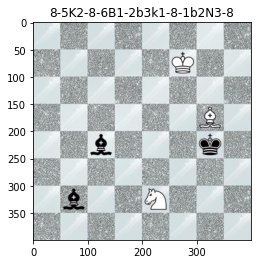

In [27]:
rand = np.random.randint(0, train_size)
img_path =train[0]
img_moves =  get_label(img_path)
img_rand=cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img_rand, cv2.COLOR_BGR2RGB))
plt.title(img_moves)
plt.show()

Text(0.5, 1.0, 'Average ratio: 1.0')

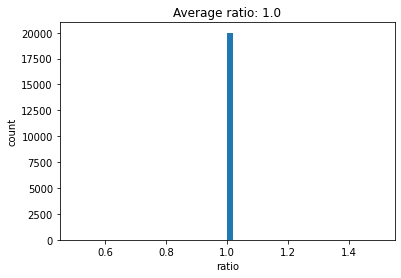

In [28]:
ratios = []

for img in train:
  img= cv2.imread(img)
  ratios.append(img.shape[1] / img.shape[0])  




plt.hist(ratios, bins=50)
plt.xlabel('ratio')
plt.ylabel('count')
plt.title('Average ratio: {}'.format(np.mean(ratios)))


In [30]:
def image_to_squares(img,heights,widths):
  squares = []
  for i in range(0,8):
    for j in range(0,8):
      squares.append(img[i*heights//8:i*heights//8+heights//8,j*widths//8:j*widths//8+widths//8])
  return np.array(squares)

In [31]:
def preprocess_image(img_path):
    height =240
    width =240

    img = cv2.imread(img_path, cv2.COLOR_BGR2GRAY)
  
    gray_image = cv2.resize(img, (width, height))
    
    gray_image =(gray_image - np.min(gray_image)) / (np.max(gray_image) - np.min(gray_image))

    squares = image_to_squares(gray_image,height,width)
    return squares

In [32]:
def onehot_from_fen(fen):
    eye = np.eye(13)
    output = np.empty((0, 13))
    fen = re.sub('[-]', '', fen)

    for char in fen:
        if(char in '12345678'):
            output = np.append(
              output, np.tile(eye[12], (int(char), 1)), axis=0)
        else:
            idx = piece_symbols.index(char)
            output = np.append(output, eye[idx].reshape((1, 13)), axis=0)

    return output

def fen_from_onehot(one_hot):
    output = ''
    for j in range(8):
        for i in range(8):
            if(one_hot[j][i] == 12):
                output += ' '
            else:
                output += piece_symbols[one_hot[j][i]]
        if(j != 7):
            output += '-'

    for i in range(8, 0, -1):
        output = output.replace(' ' * i, str(i))

    return output

In [33]:
def train_gen(data):
    for i, img in enumerate(data):
        y = onehot_from_fen(get_label(img))
        x = preprocess_image(img)
        yield x, y

def pred_gen(data):
    for i, img in enumerate(data):
        y = onehot_from_fen(get_label(img))
        x = preprocess_image(img)
        yield x, y

In [34]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

# Add a convolutional layer
model = Sequential()
model.add(Convolution2D(32, (3, 3),activation='relu', input_shape=(30, 30, 3)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Convolution2D(16, (5, 5),activation='relu'))
model.add(Dropout(0.8))
model.add(Flatten())
model.add(Dropout(0.35))
model.add(Dense(13, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 16)          12816     
                                                                 
 dropout (Dropout)           (None, 5, 5, 16)          0         
                                                                 
 flatten (Flatten)           (None, 400)               0         
                                                                 
 dropout_1 (Dropout)         (None, 400)               0         
                                                        

In [35]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [36]:
EPOCHS=50

print("\nTraining Progress:\n------------------------")
hist = model.fit_generator(train_gen(train), steps_per_epoch=train_size//EPOCHS, epochs=EPOCHS,
                           validation_data=pred_gen(test), validation_steps=test_size//EPOCHS)


Training Progress:
------------------------
Epoch 1/50
400/400 [==============================] - 21s 50ms/step - loss: 0.6146 - accuracy: 0.8241 - val_loss: 0.4128 - val_accuracy: 0.8846
Epoch 2/50
400/400 [==============================] - 19s 48ms/step - loss: 0.4052 - accuracy: 0.8676 - val_loss: 0.3138 - val_accuracy: 0.9234
Epoch 3/50
400/400 [==============================] - 22s 54ms/step - loss: 0.3463 - accuracy: 0.8872 - val_loss: 0.2434 - val_accuracy: 0.9465
Epoch 4/50
400/400 [==============================] - 19s 48ms/step - loss: 0.2949 - accuracy: 0.9022 - val_loss: 0.1865 - val_accuracy: 0.9578
Epoch 5/50
400/400 [==============================] - 19s 47ms/step - loss: 0.2504 - accuracy: 0.9130 - val_loss: 0.1541 - val_accuracy: 0.9711
Epoch 6/50
400/400 [==============================] - 19s 48ms/step - loss: 0.2159 - accuracy: 0.9260 - val_loss: 0.1465 - val_accuracy: 0.9686
Epoch 7/50
400/400 [==============================] - 19s 48ms/step - loss: 0.1894 - accura

In [37]:
pred = model.predict(pred_gen(test))

In [38]:
res = np.argmax(pred,axis=1).reshape(-1, 8, 8)

In [39]:
! pip install python-chess

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:

import chess.svg
import chess
pred_fen = fen_from_onehot(res[0])
pred_fen = pred_fen.replace('-', '/')
print(pred_fen)


4b3/3k4/1K5r/1p3R1r/2r5/3r4/5p2/3R4


In [42]:
pred_fens = np.array([fen_from_onehot(one_hot) for one_hot in res])
test_fens = np.array([get_label(fn) for fn in test])

final_accuracy = (pred_fens == test_fens).astype(float).mean()

print("Final Accuracy: {:1.5f}%".format(final_accuracy))

Final Accuracy: 0.97050%
